This python notebook is used to evaluate the style transfer during our dataset construction. 
In order to do this, we compare the reference texts (folder STYLE_REF) with the generate texts (folder STYLE_GEN). In the github repository, we only provide the generated texts, but this notebook can be used to reproduced our evaluation on another dataset constructed in the same way.
This validator is embedding-independent: it consists of a linear SVM classifier (implemented with _LinearSVC_) combined to a TF-IDF character $3$-$5$-grams.

## Imports

In [6]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix
)

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [25]:
AUTHOR_REF_DIR = "../Texts/STYLE_REF/"
AUTHOR_GEN_DIR = "../Texts/STYLE_GEN/"

## Dataset validation

In [ ]:
def safe_read_text(path: Path) -> str:
    # Most corpora are UTF-8; errors='replace' avoids crashes on odd chars
    return path.read_text(encoding="utf-8", errors="replace")

def parse_ref_folder(folder_name: str):
    # e.g. "celine_ref" -> author="celine"
    m = re.match(r"^(?P<author>.+)_REF$", folder_name)
    return (m.group("author"), None) if m else (folder_name, None)

def parse_gen_folder(folder_name: str):
    # e.g. "celine_gen_gpt" -> author="celine", model="gpt"
    m = re.match(r"^(?P<author>.+)_(?P<model>.+)_GEN$", folder_name)
    return (m.group("author"), m.group("model")) if m else (folder_name, None)

def collect_split(root_dir: str, split: str) -> list[dict]:
    root = Path(root_dir)
    if not root.exists():
        raise FileNotFoundError(f"Folder not found: {root}")

    records = []
    # We assume the first level under root is the author folder
    for author_folder in sorted([p for p in root.iterdir() if p.is_dir()]):
        folder_name = author_folder.name

        if split == "ref":
            author, model = parse_ref_folder(folder_name)
        elif split == "gen":
            author, model = parse_gen_folder(folder_name)
        else:
            raise ValueError("split must be 'ref' or 'gen'")

        for txt_path in sorted(author_folder.rglob("*.txt")):
            records.append({
                "split": split,                      # ref or gen
                "author": author,                    # celine / proust / yourcenar ...
                "model": model,                      # gemini/gpt/mistral... (None for ref)
                "rel_path": str(txt_path.relative_to(root)),
                "filename": txt_path.name,
                "text": safe_read_text(txt_path),
            })
    return records

ref_records = collect_split(AUTHOR_REF_DIR, "ref")
gen_records = collect_split(AUTHOR_GEN_DIR, "gen")


df = pd.DataFrame(ref_records + gen_records)

print("Rows:", len(df))
print(df.groupby(["split", "author", "model"], dropna=False).size().sort_values(ascending=False).head(20))
df.head()


Rows: 1152
split  author     model  
gen    CELINE     GEMINI     96
                  GPT        96
                  MISTRAL    96
       PROUST     GEMINI     96
                  GPT        96
                  MISTRAL    96
       YOURCENAR  GEMINI     96
                  GPT        96
                  MISTRAL    96
ref    CELINE     NaN        96
       PROUST     NaN        96
       YOURCENAR  NaN        96
dtype: int64


,split,author,model,rel_path,filename,text
0,ref,CELINE,NaN,CELINE_REF/1.txt,1.txt,"Ça a débuté comme ça. Moi, j’avais jamais rien..."
1,ref,CELINE,NaN,CELINE_REF/10.txt,10.txt,"Moi d’abord la campagne, faut que je le dise t..."
2,ref,CELINE,NaN,CELINE_REF/11.txt,11.txt,On est puceau de l’Horreur comme on l’est de l...
3,ref,CELINE,NaN,CELINE_REF/12.txt,12.txt,Donc pas d’erreur ? Ce qu’on faisait à se tire...
4,ref,CELINE,NaN,CELINE_REF/13.txt,13.txt,"Si seulement j’avais encore eu le temps, mais ..."


REF: (288, 6)  GEN: (864, 6)
author
celine       96
proust       96
yourcenar    96
Name: count, dtype: int64 

author     model  
celine     gemini     96
           gpt        96
           mistral    96
proust     gemini     96
           gpt        96
           mistral    96
yourcenar  gemini     96
           gpt        96
           mistral    96
Name: count, dtype: int64

VALIDATOR: TF-IDF char 3–5grams + LinearSVC
REF sanity acc=0.9655  macroF1=0.9645
GEN acc=0.6644  macroF1=0.6693

              precision    recall  f1-score   support

      PROUST      0.588     0.601     0.595       288
      CELINE      0.874     0.722     0.791       288
   YOURCENAR      0.581     0.670     0.623       288

    accuracy                          0.664       864
   macro avg      0.681     0.664     0.669       864
weighted avg      0.681     0.664     0.669       864



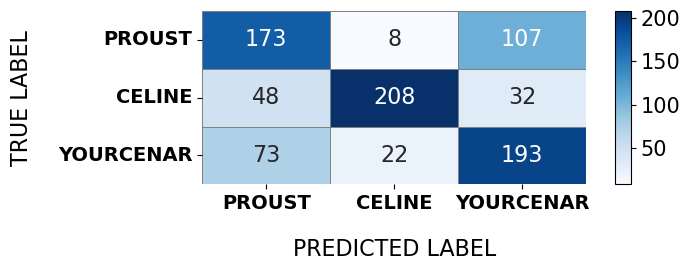


Per-generator confusion matrices (GEN only):

[GPT] confusion matrix (counts)


,PROUST,CELINE,YOURCENAR
PROUST,47,5,44
CELINE,30,52,14
YOURCENAR,31,3,62


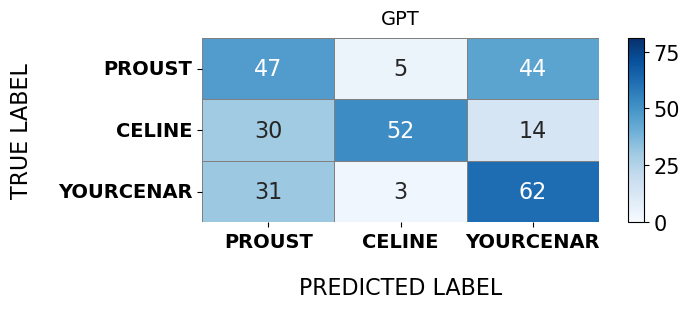


[MISTRAL] confusion matrix (counts)


,PROUST,CELINE,YOURCENAR
PROUST,81,3,12
CELINE,9,78,9
YOURCENAR,22,14,60


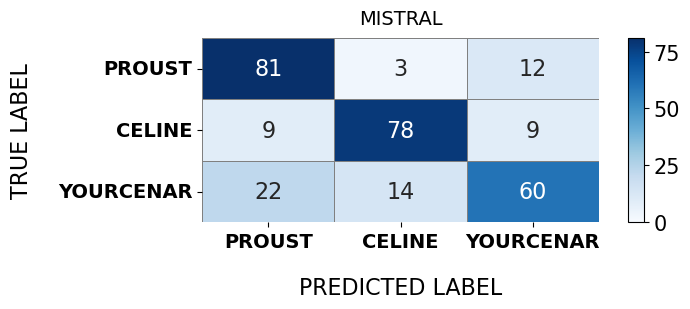


[GEMINI] confusion matrix (counts)


,PROUST,CELINE,YOURCENAR
PROUST,45,0,51
CELINE,9,78,9
YOURCENAR,20,5,71


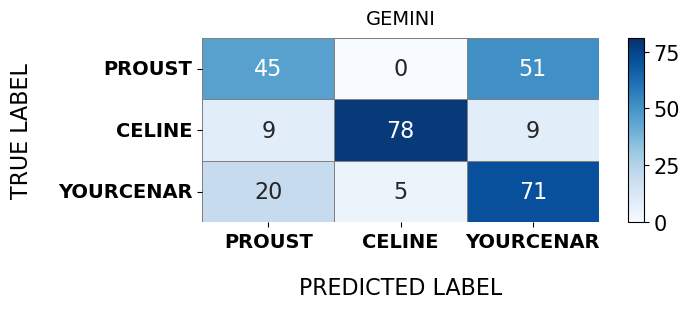

Per-generator (GEN):
  gpt: acc=0.559  macroF1=0.567
  mistral: acc=0.760  macroF1=0.758
  gemini: acc=0.674  macroF1=0.675

Per-generator × author (GEN only):
  gpt × proust: n=96  acc=0.490  pred=[proust:47, celine:5, yourcenar:44]
  gpt × celine: n=96  acc=0.542  pred=[proust:30, celine:52, yourcenar:14]
  gpt × yourcenar: n=96  acc=0.646  pred=[proust:31, celine:3, yourcenar:62]
  mistral × proust: n=96  acc=0.844  pred=[proust:81, celine:3, yourcenar:12]
  mistral × celine: n=96  acc=0.812  pred=[proust:9, celine:78, yourcenar:9]
  mistral × yourcenar: n=96  acc=0.625  pred=[proust:22, celine:14, yourcenar:60]
  gemini × proust: n=96  acc=0.469  pred=[proust:45, celine:0, yourcenar:51]
  gemini × celine: n=96  acc=0.812  pred=[proust:9, celine:78, yourcenar:9]
  gemini × yourcenar: n=96  acc=0.740  pred=[proust:20, celine:5, yourcenar:71]

Per-generator × author table (GEN only):


,generator,true_author,true_author_label,n,acc,pred_proust,pred_celine,pred_yourcenar
0,gpt,proust,PROUST,96,0.489583,47,5,44
1,gpt,celine,CELINE,96,0.541667,30,52,14
2,gpt,yourcenar,YOURCENAR,96,0.645833,31,3,62
3,mistral,proust,PROUST,96,0.843750,81,3,12
4,mistral,celine,CELINE,96,0.812500,9,78,9
5,mistral,yourcenar,YOURCENAR,96,0.625000,22,14,60
6,gemini,proust,PROUST,96,0.468750,45,0,51
7,gemini,celine,CELINE,96,0.812500,9,78,9
8,gemini,yourcenar,YOURCENAR,96,0.739583,20,5,71



Per-author (GEN only, all LLMs pooled):
  proust: n=288  acc=0.601  pred=[proust:173, celine:8, yourcenar:107]
  celine: n=288  acc=0.722  pred=[proust:48, celine:208, yourcenar:32]
  yourcenar: n=288  acc=0.670  pred=[proust:73, celine:22, yourcenar:193]

Per-author pooled table (GEN only, all LLMs):


,true_author,true_author_label,n,acc,pred_proust,pred_celine,pred_yourcenar
0,proust,PROUST,288,0.600694,173,8,107
1,celine,CELINE,288,0.722222,48,208,32
2,yourcenar,YOURCENAR,288,0.670139,73,22,193



Macro per-author acc (pooled): 0.664
Weighted per-author acc (pooled): 0.664  (== GEN overall acc)

Permutation test on GEN (labels shuffled):
  Null acc mean±std: 0.333±0.016
  Null f1  mean±std: 0.332±0.016
  p(acc)=0.000050  p(macroF1)=0.000050

=== Results ===


,model,ref_acc,ref_f1,gen_acc,gen_f1
0,TF-IDF char 3–5grams + LinearSVC,0.965517,0.964519,0.664352,0.669319


In [43]:
TARGET_AUTHORS = ["proust", "celine", "yourcenar"]
GEN_MODELS = ["gpt", "mistral", "gemini"]

# -------------------------
# Normalize + filter
# -------------------------
d = df.copy()
d["split"]  = d["split"].astype(str).str.strip().str.lower()
d["author"] = d["author"].astype(str).str.strip().str.lower()
d["model"]  = d["model"].astype(str).str.strip().str.lower()

# keep only the 3 target authors (drop tuffery entirely)
d = d[d["author"].isin(TARGET_AUTHORS)].copy()

# Robust split parsing:
# works for "ref"/"gen" and also corpus names ending with "_ref"/"_gen"
is_ref = d["split"].str.endswith("ref")
is_gen = d["split"].str.endswith("gen")

ref = d[is_ref].copy()
gen = d[is_gen & d["model"].isin(GEN_MODELS)].copy()

print("REF:", ref.shape, " GEN:", gen.shape)
print(ref["author"].value_counts(), "\n")
print(gen[["author", "model"]].value_counts().head(12))

# # =========================
# # VALIDATION (TF-IDF char 3–5grams + LinearSVC)
# # =========================



RANDOM_SEED = 42
TEST_SIZE_REF_SANITY = 0.10

X_ref = ref["text"].astype(str).tolist()
y_ref = ref["author"].astype(str).tolist()

X_gen = gen["text"].astype(str).tolist()
y_gen = gen["author"].astype(str).tolist()
gname = gen["model"].astype(str).tolist()

# Same REF split reused for all validators
X_tr, X_te, y_tr, y_te = train_test_split(
    X_ref, y_ref,
    test_size=TEST_SIZE_REF_SANITY,
    random_state=RANDOM_SEED,
    stratify=y_ref
)

def permutation_test(y_true, y_pred, n_perm=20000, seed=42):
    """Permutation test for (acc, macro-F1) significance above chance."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    obs_acc = accuracy_score(y_true, y_pred)
    obs_f1  = f1_score(y_true, y_pred, average="macro")

    rng = np.random.default_rng(seed)
    acc_null = np.empty(n_perm, dtype=float)
    f1_null  = np.empty(n_perm, dtype=float)

    for i in range(n_perm):
        y_perm = rng.permutation(y_true)
        acc_null[i] = accuracy_score(y_perm, y_pred)
        f1_null[i]  = f1_score(y_perm, y_pred, average="macro")

    p_acc = (np.sum(acc_null >= obs_acc) + 1) / (n_perm + 1)
    p_f1  = (np.sum(f1_null  >= obs_f1)  + 1) / (n_perm + 1)

    return obs_acc, obs_f1, p_acc, p_f1, acc_null.mean(), acc_null.std(), f1_null.mean(), f1_null.std()

def plot_cm_heatmap(cm_df, title=None, figsize=(7, 2.8), vmin=None, vmax=None):
    """
    Plot a confusion matrix heatmap with the same style as your original code.
    cm_df: DataFrame indexed/columned by pretty label names.
    """
    fig, ax = plt.subplots(figsize=figsize)

    cmap = plt.cm.Blues
    if vmin is None:
        vmin = float(cm_df.to_numpy().min())
    if vmax is None:
        vmax = float(cm_df.to_numpy().max())

    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar=False,  # we add our own colorbar axis
        linewidths=0.5,
        linecolor="gray",
        annot_kws={"fontsize": 16, "va": "center", "fontweight": "normal"},
        ax=ax,
    )

    ax.set_title("" if title is None else title, fontsize=14, pad=10)
    ax.set_xlabel("PREDICTED LABEL", fontsize=16, labelpad=18, fontweight="normal")
    ax.set_ylabel("TRUE LABEL", fontsize=16, labelpad=18, fontweight="normal")

    plt.xticks(rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)
    for lab in ax.get_xticklabels() + ax.get_yticklabels():
        lab.set_fontweight("bold")

    # colorbar: thicker + exactly same height as heatmap axis
    CBAR_WIDTH = "4%"
    CBAR_PAD = 0.29

    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("right", size=CBAR_WIDTH, pad=CBAR_PAD)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=15)
    for tl in cbar.ax.get_yticklabels():
        tl.set_fontweight("normal")

    fig.tight_layout()
    plt.show()

def run_validator(name, pipeline, do_perm=True):
    print("\n" + "="*70)
    print("VALIDATOR:", name)
    print("="*70)

    pipeline.fit(X_tr, y_tr)

    # REF sanity
    ref_pred = pipeline.predict(X_te)
    ref_acc = accuracy_score(y_te, ref_pred)
    ref_f1  = f1_score(y_te, ref_pred, average="macro")
    print(f"REF sanity acc={ref_acc:.4f}  macroF1={ref_f1:.4f}")

    # GEN evaluation
    gen_pred = pipeline.predict(X_gen)
    gen_acc = accuracy_score(y_gen, gen_pred)
    gen_f1  = f1_score(y_gen, gen_pred, average="macro")
    print(f"GEN acc={gen_acc:.4f}  macroF1={gen_f1:.4f}\n")

    # Explicit GEN-only eval table (prevents any accidental REF usage)
    gen_eval = gen[["model", "author"]].copy().reset_index(drop=True)
    gen_eval.columns = ["generator", "true_author"]
    gen_eval["pred_author"] = pd.Series(gen_pred).astype(str).values

    # Classification report with uppercase label names
    labels = TARGET_AUTHORS
    target_names = ["PROUST", "CELINE", "YOURCENAR"]
    label_map = {"proust": "PROUST", "celine": "CELINE", "yourcenar": "YOURCENAR"}

    print(classification_report(
        gen_eval["true_author"], gen_eval["pred_author"],
        labels=labels,
        target_names=target_names,
        digits=3,
        zero_division=0
    ))

    # ----------------------------
    # Confusion matrix (GEN overall)
    # ----------------------------
    cm = confusion_matrix(gen_eval["true_author"], gen_eval["pred_author"], labels=labels)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

    plot_cm_heatmap(cm_df, title=None, figsize=(7, 2.8))

    # ----------------------------
    # Confusion matrices per generator (GEN only)
    # ----------------------------
    print("\nPer-generator confusion matrices (GEN only):")

    # Precompute all CMs first so we can share a common color scale across generators
    cm_by_generator = {}
    global_vmax = 0
    for m in GEN_MODELS:
        sub = gen_eval[gen_eval["generator"] == m]
        if sub.empty:
            continue
        cm_m = confusion_matrix(sub["true_author"], sub["pred_author"], labels=labels)
        cm_by_generator[m] = cm_m
        global_vmax = max(global_vmax, int(cm_m.max()))

    for m in GEN_MODELS:
        sub = gen_eval[gen_eval["generator"] == m]
        if sub.empty:
            print(f"\n[{m.upper()}] no samples")
            continue

        cm_m = cm_by_generator[m]
        cm_m_df = pd.DataFrame(cm_m, index=target_names, columns=target_names)

        print(f"\n[{m.upper()}] confusion matrix (counts)")
        display(cm_m_df)

        # Slightly larger height so titles remain readable
        plot_cm_heatmap(
            cm_m_df,
            title=f"{m.upper()}",
            figsize=(7, 3.2),
            vmin=0,
            vmax=float(global_vmax) if global_vmax > 0 else None
        )

    # Per-generator (GEN only)
    print("Per-generator (GEN):")
    for m in GEN_MODELS:
        sub = gen_eval[gen_eval["generator"] == m]
        if sub.empty:
            print(f"  {m}: (no samples)")
            continue
        acc_m = accuracy_score(sub["true_author"], sub["pred_author"])
        f1_m  = f1_score(sub["true_author"], sub["pred_author"], average="macro")
        print(f"  {m}: acc={acc_m:.3f}  macroF1={f1_m:.3f}")

    # Per-generator × author (GEN only)
    print("\nPer-generator × author (GEN only):")
    rows = []
    for m in GEN_MODELS:
        for a in TARGET_AUTHORS:
            sub = gen_eval[(gen_eval["generator"] == m) & (gen_eval["true_author"] == a)]
            if sub.empty:
                print(f"  {m} × {a}: (no samples)")
                continue

            # On a fixed true-author subset, accuracy = recall for that author within this generator
            acc = accuracy_score(sub["true_author"], sub["pred_author"])
            pred_counts = (
                sub["pred_author"]
                .value_counts()
                .reindex(TARGET_AUTHORS, fill_value=0)
            )

            print(
                f"  {m} × {a}: n={len(sub)}  acc={acc:.3f}  "
                f"pred=[proust:{pred_counts['proust']}, "
                f"celine:{pred_counts['celine']}, "
                f"yourcenar:{pred_counts['yourcenar']}]"
            )

            rows.append({
                "generator": m,
                "true_author": a,
                "true_author_label": label_map.get(a, a.upper()),
                "n": int(len(sub)),
                "acc": float(acc),
                "pred_proust": int(pred_counts["proust"]),
                "pred_celine": int(pred_counts["celine"]),
                "pred_yourcenar": int(pred_counts["yourcenar"]),  # kept column name for compatibility
            })

    per_model_author_df = pd.DataFrame(rows)
    print("\nPer-generator × author table (GEN only):")
    display(per_model_author_df)

    # ----------------------------
    # Per-author (GEN only, all LLMs pooled)
    # ----------------------------
    print("\nPer-author (GEN only, all LLMs pooled):")
    pooled_rows = []
    for a in TARGET_AUTHORS:
        sub = gen_eval[gen_eval["true_author"] == a]
        if sub.empty:
            print(f"  {a}: (no samples)")
            continue

        # On a fixed true-author subset, accuracy = recall for that author
        acc_a = accuracy_score(sub["true_author"], sub["pred_author"])

        pred_counts = (
            sub["pred_author"]
            .value_counts()
            .reindex(TARGET_AUTHORS, fill_value=0)
        )

        print(
            f"  {a}: n={len(sub)}  acc={acc_a:.3f}  "
            f"pred=[proust:{pred_counts['proust']}, "
            f"celine:{pred_counts['celine']}, "
            f"yourcenar:{pred_counts['yourcenar']}]"
        )

        pooled_rows.append({
            "true_author": a,
            "n": int(len(sub)),
            "acc": float(acc_a),  # same as recall on this subset
            "pred_proust": int(pred_counts["proust"]),
            "pred_celine": int(pred_counts["celine"]),
            "pred_yourcenar": int(pred_counts["yourcenar"]),  # kept column name for compatibility
        })

    per_author_pooled_df = pd.DataFrame(pooled_rows)

    # Optional pretty labels
    if not per_author_pooled_df.empty:
        per_author_pooled_df["true_author_label"] = per_author_pooled_df["true_author"].map(label_map)
        per_author_pooled_df = per_author_pooled_df[
            ["true_author", "true_author_label", "n", "acc",
             "pred_proust", "pred_celine", "pred_yourcenar"]
        ]

    print("\nPer-author pooled table (GEN only, all LLMs):")
    display(per_author_pooled_df)

    # Optional summaries
    if not per_author_pooled_df.empty:
        macro_per_author_acc = per_author_pooled_df["acc"].mean()
        weighted_per_author_acc = np.average(
            per_author_pooled_df["acc"],
            weights=per_author_pooled_df["n"]
        )
        print(f"\nMacro per-author acc (pooled): {macro_per_author_acc:.3f}")
        print(f"Weighted per-author acc (pooled): {weighted_per_author_acc:.3f}  (== GEN overall acc)")

    # Permutation test (GEN)
    if do_perm:
        obs_acc, obs_f1, p_acc, p_f1, mu_acc, sd_acc, mu_f1, sd_f1 = permutation_test(
            gen_eval["true_author"].tolist(),
            gen_eval["pred_author"].tolist(),
            n_perm=20000,
            seed=RANDOM_SEED
        )
        print("\nPermutation test on GEN (labels shuffled):")
        print(f"  Null acc mean±std: {mu_acc:.3f}±{sd_acc:.3f}")
        print(f"  Null f1  mean±std: {mu_f1:.3f}±{sd_f1:.3f}")
        print(f"  p(acc)={p_acc:.6f}  p(macroF1)={p_f1:.6f}")

    return {
        "model": name,
        "ref_acc": ref_acc,
        "ref_f1": ref_f1,
        "gen_acc": gen_acc,
        "gen_f1": gen_f1
    }

# --- The one baseline ---
char_svc = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3, 5), min_df=2)),
    ("clf", LinearSVC())
])

results = [run_validator("TF-IDF char 3–5grams + LinearSVC", char_svc)]

res_df = pd.DataFrame(results)
print("\n=== Results ===")
display(res_df)